In [11]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import math
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu

def cart2sph(point):
    XsqPlusYsq = point[0]**2 + point[1]**2
    r = math.sqrt(XsqPlusYsq + point[2]**2)               # r
    elev = math.atan2(point[2],math.sqrt(XsqPlusYsq))     # theta
    az = math.atan2(point[1],point[0])                    # phi
    return np.array([r, elev, az])

def resection_with_2_known_points(point_ref_1, point_ref_2, point_meas_1, point_meas_2):
    #s1 = cart2sph(point_meas_1)
    #s2 = cart2sph(point_meas_2)
    
    station_z = ((point_ref_1[2] - point_meas_1[2]) + 
                 (point_ref_2[2] - point_meas_2[2]))/2
                  
    # find the position of the total station using the intersection of 2 circles given by the measurements of the prism position.
    radius_1 = np.sqrt(point_meas_1[0]**2+point_meas_1[1]**2)
    radius_2 = np.sqrt(point_meas_2[0]**2+point_meas_2[1]**2)
    
    delta_x = point_ref_2[0] - point_ref_1[0]
    delta_y = point_ref_2[1] - point_ref_1[1]
    
    # find the y value based on the intersection of 2 circles aligned in x (same value of x)
    #x = (radius_1**2 - radius_2**2 - point1[0]**2 + point2[0]**2)/(2*delta_x)
    #y_1_1 = np.sqrt(radius_1**2 -(x - point1[0])**2)
    #y_2_1 = -np.sqrt(radius_1**2 -(x - point1[0])**2)
    #y_1_2 = np.sqrt(radius_2**2 -(x - point2[0])**2)
    #y_2_2 = -np.sqrt(radius_2**2 -(x - point2[0])**2)
    #station_pos_complete_1 = np.array([x, np.mean([y_1_1, y_1_2]), station_z, 0, 0, 0])   
    #station_pos_complete_2 = np.array([x, np.mean([y_2_1, y_2_2]), station_z, 0, 0, 0])
    
    # find the possible values of x based on the quadratic formula and the circle formula knowing y
    y = (radius_1**2 - radius_2**2 - point_ref_1[1]**2 + point_ref_2[1]**2)/(2*delta_y)
    x_1_1 = np.sqrt(radius_1**2 - (y - point_ref_1[1])**2)
    x_2_1 = -np.sqrt(radius_1**2 - (y - point_ref_1[1])**2)   
    x_1_2 = np.sqrt(radius_2**2 - (y - point_ref_2[1])**2)
    x_2_2 = -np.sqrt(radius_2**2 - (y - point_ref_2[1])**2)
    
    l12 = np.sqrt((point_ref_1[0]-point_ref_2[0])**2+(point_ref_1[1]-point_ref_2[1])**2)
    l1p = radius_1
    l2p = radius_2
    
    perimeter = (l12+l1p+l2p)/2
    S = np.sqrt(perimeter*(perimeter-l12)*(perimeter-l1p)*(perimeter-l2p))
    L2 = (l12**2+l1p**2-l2p**2)
    
    #Xp = point_ref_1[0] + abs(delta_x)*(L2**2/(2*l12**2))-abs(delta_y)*(2*S/l12**2)
    #Yp = point_ref_1[1] + abs(delta_y)*(L2**2/(2*l12**2))+abs(delta_x)*(2*S/l12**2)

    station_pos_complete_1 = np.array([np.mean([x_1_1, x_1_2]), y, station_z, 0, 0, 0])   
    station_pos_complete_2 = np.array([np.mean([x_2_1, x_2_2]), y, station_z, 0, 0, 0])
    
    #station_pos_complete_1 = np.array([Xp, Yp, station_z, 0, 0, 0])   
    #station_pos_complete_2 = np.array([Xp, Yp, station_z, 0, 0, 0])   
    
    return [station_pos_complete_1, station_pos_complete_2]

# def calculate_tf_angle(point1, ref_point, station_pose):
#     T = np.identity(4)
#     dx1 = point1[0] - station_pose[0]
#     dy1 = point1[1] - station_pose[1]
#     dxref = ref_point[0] - station_pose[0]
#     dyref = ref_point[1] - station_pose[1]
#     if dyref >= 0:
#         if dx1 <= 0:
#             if dy1 >= 0:
#                 theta1 = np.arctan2(dy1, abs(dx1))
#                 theta2 = np.arctan2(dyref, dxref)
#                 thetaR = -(np.pi - theta1 - theta2)
#             else:
#                 theta1 = np.arctan2(abs(dy1), abs(dx1))
#                 theta2 = np.arctan2(dyref, dxref)
#                 thetaR = -(np.pi + theta1 - theta2)
#         else:
#             if dy1 >= 0:
#                 theta1 = np.arctan2(dy1, dx1)
#                 theta2 = np.arctan2(dyref, dxref)
#                 thetaR = -(theta1 - theta2)
#             else:
#                 theta1 = np.arctan2(abs(dy1), dx1)
#                 theta2 = np.arctan2(dyref, dxref)
#                 thetaR = -(theta2 + theta1)
#     else:
#         if dx1 <= 0:
#             if dy1 >= 0:
#                 theta1 = np.arctan2(dy1, abs(dx1))
#                 theta2 = np.arctan2(abs(dyref), dxref)
#                 thetaR = (np.pi + theta1 - theta2)
#             else:
#                 theta1 = np.arctan2(abs(dy1), abs(dx1))
#                 theta2 = np.arctan2(abs(dyref), dxref)
#                 thetaR = (np.pi - theta1 - theta2)
#         else:
#             if dy1 >= 0:
#                 theta1 = np.arctan2(dy1, dx1)
#                 theta2 = np.arctan2(abs(dyref), dxref)
#                 thetaR = -(theta1 + theta2)
#             else:
#                 theta1 = np.arctan2(abs(dy1), dx1)
#                 theta2 = np.arctan2(abs(dyref), dxref)
#                 thetaR = -(theta2 - theta1)
#     Rot_r = np.array([[np.cos(thetaR), -np.sin(thetaR), 0],
#                  [np.sin(thetaR), np.cos(thetaR), 0],
#                  [0, 0, 1]])
#     T[0:3,0:3]=Rot_r
#     return T

def calculate_tf_angle_using_scalar_product(measured_points, reference_points, calib_index):
    angle = 0
    if calib_index==0:
        measured_line = measured_points[0][:3] - measured_points[1][:3]
        reference_line = reference_points[0] - reference_points[1]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[0][0]>reference_points[0][0]:
            angle = -angle
    elif calib_index==1:
        measured_line = measured_points[0][:3] - measured_points[2][:3]
        reference_line = reference_points[0] - reference_points[2]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[0][0]>reference_points[0][0]:
            angle = -angle
    elif calib_index==2:
        measured_line = measured_points[0][:3] - measured_points[3][:3]
        reference_line = reference_points[0] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        print(measured_line)
        print(reference_line)
        print(angle)
        if measured_points[0][0]>reference_points[0][0]:
            angle = -angle
    elif calib_index==3:
        measured_line = measured_points[1][:3] - measured_points[2][:3]
        reference_line = reference_points[1] - reference_points[2]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[1][0]>reference_points[1][0]:
            angle = -angle
    elif calib_index==4:
        measured_line = measured_points[1][:3] - measured_points[3][:3]
        reference_line = reference_points[1] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[1][0]>reference_points[1][0]:
            angle = -angle
    elif calib_index==5:
        measured_line = measured_points[2][:3] - measured_points[3][:3]
        reference_line = reference_points[2] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[2][0]<reference_points[2][0]:
            angle = -angle
    T = np.identity(4)
    Rot_r = np.array([[np.cos(angle), -np.sin(angle), 0],
                 [np.sin(angle), np.cos(angle), 0],
                 [0, 0, 1]])
    T[0:3,0:3]=Rot_r
    print(T)
    return T

In [13]:
%matplotlib inline

pilier_A = np.array([0, 0, 0])
pilier_B = np.array([0, np.sqrt(181.016**2 - 0.323**2), 0.323])
pilier_C = np.array([0, np.sqrt(363.492**2 - 1.038**2), 1.038])
pilier_D = np.array([0, np.sqrt(548.578**2 - 2.374**2), 2.374])

#pilier_A = np.array([0, 0, 0])
#pilier_B = np.array([np.sqrt(181.016**2 - 0.323**2), 0, 0.323])
#pilier_C = np.array([np.sqrt(363.492**2 - 1.038**2), 0, 1.038])
#pilier_D = np.array([np.sqrt(548.578**2 - 2.374**2), 0, 2.374])

#pilier_A = np.array([0, 20, 0])
#pilier_B = np.array([0, 10, 0])
#pilier_C = np.array([0, -10, 0])
#pilier_D = np.array([0, -20, 0])

liste_piliers = [pilier_A, pilier_B, pilier_C, pilier_D]

# Read markers file of grand axe and show them
tfu = importlib.reload(tfu)
ttfu = importlib.reload(ttfu)

file_name = './data/total_station/20220715_prisms_calib/theodolite_reference_prisms_geomaic.txt'

raw_1, raw_2, raw_3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = ttfu.read_marker_file_raw_data(file_name)
station_1_pos1 = []
station_1_pos2 = []
station_2_pos1 = []
station_2_pos2 = []
station_3_pos1 = []
station_3_pos2 = []

for i in range(len(liste_piliers)):
    for j in range(i+1, len(liste_piliers)):
        print(i,j)
        possible_poses_station_1 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_1[i], raw_1[j])
        for pose, station in zip(possible_poses_station_1, [station_1_pos1, station_1_pos2]):
            station.append(pose)
        possible_poses_station_2 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_2[i], raw_2[j])
        for pose, station in zip(possible_poses_station_2, [station_2_pos1, station_2_pos2]):
            station.append(pose)
        possible_poses_station_3 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_3[i], raw_3[j])
        for pose, station in zip(possible_poses_station_3, [station_3_pos1, station_3_pos2]):
            station.append(pose)

#station_1_pos1, station_1_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_1[0], raw_1[1])
#station_2_pos1, station_2_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_2[0], raw_2[1])
#station_3_pos1, station_3_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_3[0], raw_3[1])
print("Sation 1:")
print("possible position 1: ", station_1_pos1)
print("possible position 2: ", station_1_pos2)
print("Station 2:")
print("possible position 1: ", station_2_pos1)
print("possible position 2: ", station_2_pos2)
print("Station 3:")
print("possible position 1: ", station_3_pos1)
print("possible position 2: ", station_3_pos2)

0 1
0 2
0 3
1 2
1 3
2 3
Sation 1:
possible position 1:  [array([ 15.18614491, 288.72102859,   1.03852038,   0.        ,
         0.        ,   0.        ]), array([ 15.17814444, 288.72144929,   1.03788105,   0.        ,
         0.        ,   0.        ]), array([ 15.16278431, 288.72225636,   1.04323001,   0.        ,
         0.        ,   0.        ]), array([ 15.18020012, 288.72186662,   1.03739368,   0.        ,
         0.        ,   0.        ]), array([ 15.17314301, 288.72286102,   1.04274263,   0.        ,
         0.        ,   0.        ]), array([ 15.18992351, 288.72384141,   1.04210331,   0.        ,
         0.        ,   0.        ])]
possible position 2:  [array([-15.18614491, 288.72102859,   1.03852038,   0.        ,
         0.        ,   0.        ]), array([-15.17814444, 288.72144929,   1.03788105,   0.        ,
         0.        ,   0.        ]), array([-15.16278431, 288.72225636,   1.04323001,   0.        ,
         0.        ,   0.        ]), array([-15.18020012,

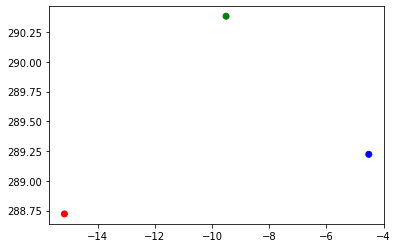

In [18]:
%matplotlib inline
plt.figure()
plt.scatter([station_1_pos2[2][0], station_2_pos2[2][0], station_3_pos2[2][0]],[station_1_pos2[2][1], station_2_pos2[2][1], station_3_pos2[2][1]],c=['r', 'g', 'b'])

In [21]:
%matplotlib inline

tfu = importlib.reload(tfu)
# choose which line is right for each total station in this section (the correct position is the first or the 2nd found with the resection)
# for i in range(len(station_1_pos1)):
#     Tf1 = tfu.tf_from_pose_roll_pitch_yaw(station_1_pos1[i])
#     Tf12 = ttfu.tf_from_pose_roll_pitch_yaw(station_1_pos2[i])

#     Tf2 = tfu.tf_from_pose_roll_pitch_yaw(station_2_pos1[i])
#     Tf22 = ttfu.tf_from_pose_roll_pitch_yaw(station_2_pos2[i])

#     Tf3 = tfu.tf_from_pose_roll_pitch_yaw(station_3_pos1[i])
#     Tf32 = ttfu.tf_from_pose_roll_pitch_yaw(station_3_pos2[i])
#     print(Tf1)
#     print(Tf12)
#     print(Tf2)
#     print(Tf22)
#     print(Tf3)
#     print(Tf32)
TF1 = []
TF2 = []
TF3 = []
tp1 = []
tp2 = []
tp3 = []
TR1 = []
TR2 = []
TR3 = []

for i in range(len(station_1_pos2)):
# i = 2
    TF1.append(tfu.tf_from_pose_roll_pitch_yaw(station_1_pos2[i]))
    TF2.append(tfu.tf_from_pose_roll_pitch_yaw(station_2_pos2[i]))
    TF3.append(tfu.tf_from_pose_roll_pitch_yaw(station_3_pos2[i]))
    #print(TF1)
    #print(TF2)
    #print(TF3)
    print(trimble_1)
    print(trimble_2)
    print(trimble_3)
    tp1.append(TF1[i]@trimble_1)
    tp2.append(TF2[i]@trimble_2)
    tp3.append(TF3[i]@trimble_3)
    tp1[i] = tp1[i].T
    tp2[i] = tp2[i].T
    tp3[i] = tp3[i].T

    #print(tp1)
    #print(tp2)
    #print(tp3)

    TR1.append(calculate_tf_angle_using_scalar_product(tp1[i], liste_piliers, i))
    TF1[i] = TF1[i]@TR1[i]
    tp1[i] = TF1[i]@trimble_1
    tp1[i] = tp1[i].T

    TR2.append(calculate_tf_angle_using_scalar_product(tp2[i], liste_piliers, i))
    TF2[i] = TF2[i]@TR2[i]
    tp2[i] = TF2[i]@trimble_2
    tp2[i] = tp2[i].T

    TR3.append(calculate_tf_angle_using_scalar_product(tp3[i], liste_piliers, i))
    TF3[i] = TF3[i]@TR3[i]
    tp3[i] = TF3[i]@trimble_3
    tp3[i] = tp3[i].T

[[ 2.82595797e+02  1.03902109e+02 -7.62333552e+01 -2.58938355e+02]
 [ 6.10742720e+01  3.21777267e+01  3.04388698e+00 -2.65174678e+01]
 [-1.03900775e+00 -7.15033006e-01  1.24563812e-03  1.32654774e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
[[-9.06057649e+01 -2.85144755e+01  3.40831015e+01  9.75651731e+01]
 [-2.76049922e+02 -1.06016929e+02  6.53795425e+01  2.39234849e+02]
 [-1.05282333e+00 -7.21698662e-01 -2.48273215e-03  1.32188935e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
[[ 2.87512749e+02  1.07926858e+02 -7.31070586e+01 -2.56729143e+02]
 [-3.17304282e+01 -9.03137407e+00  1.38566672e+01  3.70529809e+01]
 [-9.72974277e-01 -6.45897762e-01  7.33912827e-02  1.39716871e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
[[ 2.82595797e+02  1.03902109e+02 -7.62333552e+01 -2.58938355e+02]
 [ 6.10742720e+01  3.21777267e+01  3.04388698e+00 -2.65174678e+01]
 [-1.03900775e+00 -7.15033006e-01  1.24563812e-03  1.326547

[0.0036583871035307824, 0.028967658626262636, 0.02822972272199584, 0.003595650871975576, 0.0288070124745799, 0.02885875187883471, 0.03332940841252395, 0.011951761391541277, 0.021485823015335994, 0.037636198394681075, 0.012842072487865737, 0.024914539245178266, 0.059306734388878214, 0.04240145852825037, 0.016985308913913113, 0.07314201670447532, 0.045387669052804655, 0.02778493092612838, 0.02514783014562097, 0.0020164293877668136, 0.023771297056937295, 0.029130727555026572, 0.002756594374070669, 0.026865762790945776, 0.033133015199843, 0.010729361235415855, 0.022455857756269456, 0.04845881621812984, 0.014070417389255446, 0.03439886537493901, 0.019346804036263696, 0.010445080476797005, 0.029449013069237067, 0.032004358880046185, 0.00761347075530484, 0.03948927710944863]
[0.01556980003176222, 0.019212921319203543, 0.031725602686839854, 0.025774152610536987, 0.01563706877652238, 0.04027120514227391, 0.029078593792156087, 0.006996823930736315, 0.022119644052558198, 0.044435769523340746, 0.0

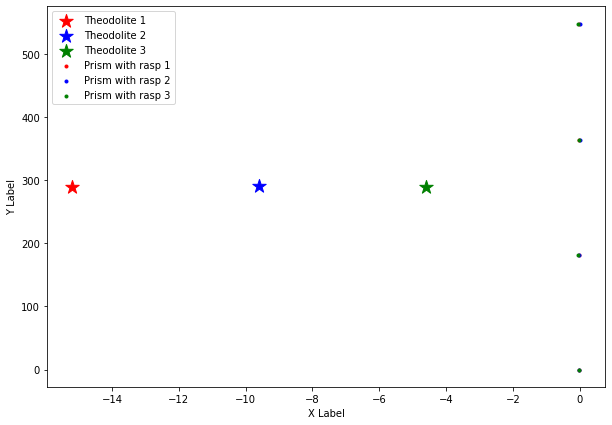

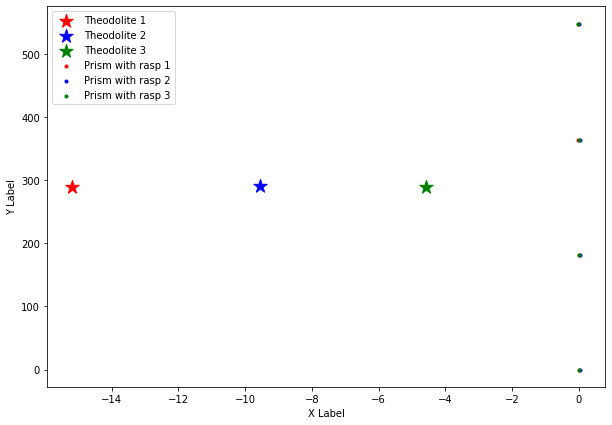

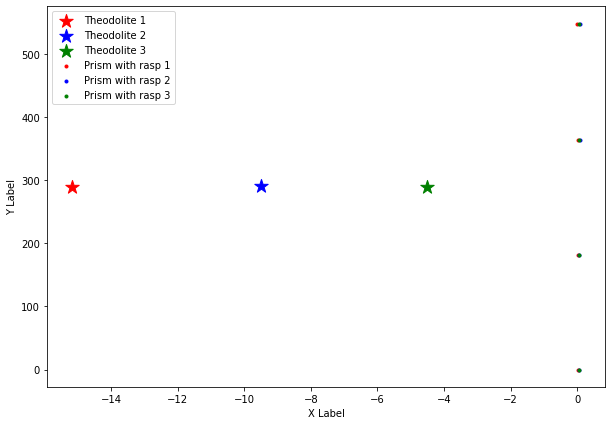

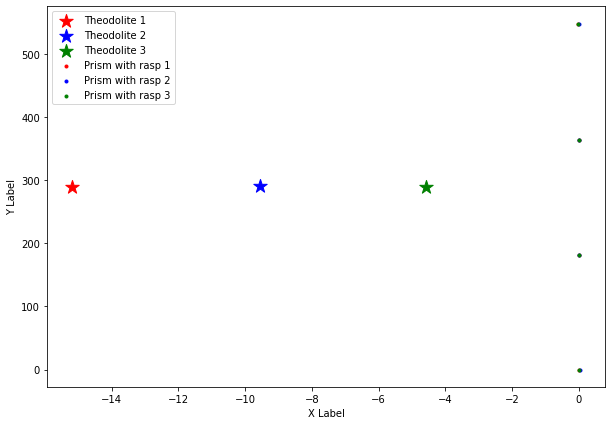

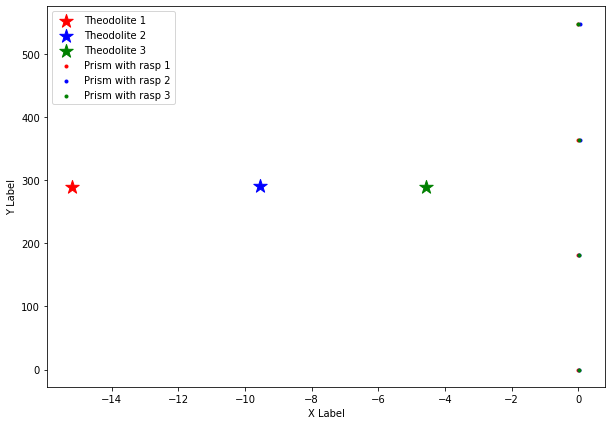

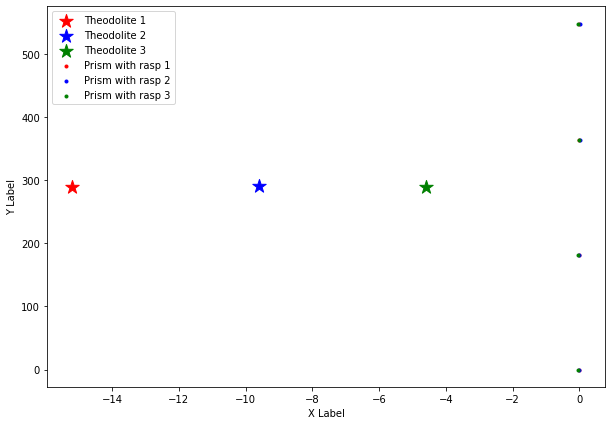

In [22]:
%matplotlib notebook
plt.figure()
plt.scatter([station_1_pos2[2][0], station_2_pos2[2][0], station_3_pos2[2][0]],[station_1_pos2[2][1], station_2_pos2[2][1], station_3_pos2[2][1]],c=['r', 'g', 'b'])

In [17]:
%matplotlib inline

tfu = importlib.reload(tfu)
# choose which line is right for each total station in this section (the correct position is the first or the 2nd found with the resection)
# for i in range(len(station_1_pos1)):
#     Tf1 = tfu.tf_from_pose_roll_pitch_yaw(station_1_pos1[i])
#     Tf12 = ttfu.tf_from_pose_roll_pitch_yaw(station_1_pos2[i])

#     Tf2 = tfu.tf_from_pose_roll_pitch_yaw(station_2_pos1[i])
#     Tf22 = ttfu.tf_from_pose_roll_pitch_yaw(station_2_pos2[i])

#     Tf3 = tfu.tf_from_pose_roll_pitch_yaw(station_3_pos1[i])
#     Tf32 = ttfu.tf_from_pose_roll_pitch_yaw(station_3_pos2[i])
#     print(Tf1)
#     print(Tf12)
#     print(Tf2)
#     print(Tf22)
#     print(Tf3)
#     print(Tf32)
TF1 = []
TF2 = []
TF3 = []
tp1 = []
tp2 = []
tp3 = []
TR1 = []
TR2 = []
TR3 = []

# for i in range(len(station_1_pos2)):
i = 2
TF1.append(tfu.tf_from_pose_roll_pitch_yaw(station_1_pos2[i]))
TF2.append(tfu.tf_from_pose_roll_pitch_yaw(station_2_pos2[i]))
TF3.append(tfu.tf_from_pose_roll_pitch_yaw(station_3_pos2[i]))
#print(TF1)
#print(TF2)
#print(TF3)
#print(trimble_1)
#print(trimble_2)
#print(trimble_3)
tp1.append(TF1[0]@trimble_1)
tp2.append(TF2[0]@trimble_2)
tp3.append(TF3[0]@trimble_3)
tp1[0] = tp1[0].T
tp2[0] = tp2[0].T
tp3[0] = tp3[0].T

#print(tp1)
#print(tp2)
#print(tp3)

TR1.append(calculate_tf_angle_using_scalar_product(tp1[0], liste_piliers, i))
TF1[0] = TF1[0]@TR1[0]
tp1[0] = TF1[0]@trimble_1
tp1[0] = tp1[0].T

TR2.append(calculate_tf_angle_using_scalar_product(tp2[0], liste_piliers, i))
TF2[0] = TF2[0]@TR2[0]
tp2[0] = TF2[0]@trimble_2
tp2[0] = tp2[0].T

TR3.append(calculate_tf_angle_using_scalar_product(tp3[0], liste_piliers, i))
TF3[0] = TF3[0]@TR3[0]
tp3[0] = TF3[0]@trimble_3
tp3[0] = tp3[0].T

[ 533.79905045 -126.40178947   -2.3766121 ]
[   0.         -548.57286317   -2.374     ]
1.3382676651780605
[[ 0.23043886  0.9730868   0.          0.        ]
 [-0.9730868   0.23043886  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[526.12076128 155.31053323  -2.37276748]
[   0.         -548.57286317   -2.374     ]
1.857818060848253
[[-0.28309706  0.95909127  0.          0.        ]
 [-0.95909127 -0.28309706  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[534.52515555 123.32840225  -2.37547971]
[   0.         -548.57286317   -2.374     ]
1.797529776855525
[[-0.22479578  0.9744059   0.          0.        ]
 [-0.9744059  -0.22479578  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


[0.012402979580108007, 0.09325119810369424, 0.10522163875197312, 0.007216330213014773, 0.09807160920004443, 0.10441337327785755]
[0.010321802504041805, 0.0911926231407902, 0.10069331907484698, 0.011452525308337106, 0.09438390619076326, 0.10467839221089982]
Median error for the control points:  95.661 mm
Median error for the validation points:  92.788 mm


<IPython.core.display.Javascript object>


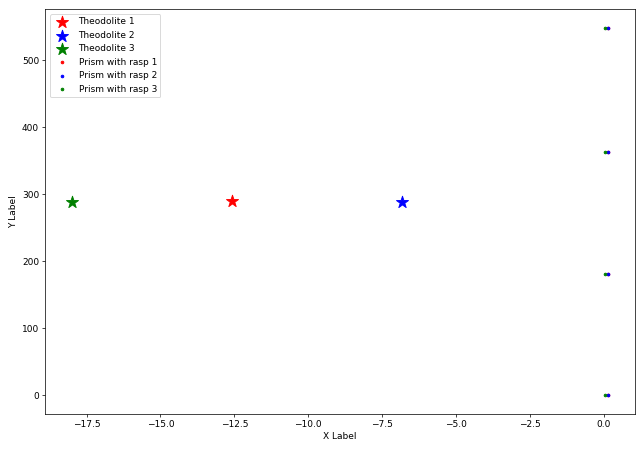

In [18]:
%matplotlib notebook

error_validation_points = []
error_control_points = []
# counter = 0
# for i,j,k in zip(tp1[0],tp2[0],tp3[0]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         #print("i: ", np.round(i, 2))
#         #print("j: ", np.round(j, 2))
#         #print("k: ", np.round(k, 2))
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter < 2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[1],tp2[1],tp3[1]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==0 or counter==2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1
error_12_x = []
error_12_y = []
error_12_z = []
error_13_x = []
error_13_y = []
error_13_z = []
error_23_x = []
error_23_y = []
error_23_z = []
error_1_x = []
error_1_y = []
error_1_z = []
error_2_x = []
error_2_y = []
error_2_z = []
error_3_x = []
error_3_y = []
error_3_z = []
counter = 0
for i,j,k in zip(tp1[2],tp2[2],tp3[2]):
        #print("i: ", i, "j: ", j, "k: ", k)
        dist_12 = np.linalg.norm(i-j)
        dist_13 = np.linalg.norm(i-k)
        dist_23 = np.linalg.norm(k-j)
        if counter==0 or counter==3:
            error_control_points.append(dist_12)
            error_control_points.append(dist_13)
            error_control_points.append(dist_23)
        else:
            error_validation_points.append(dist_12)
            error_validation_points.append(dist_13)
            error_validation_points.append(dist_23)
        error_12_x.append(i[0]-j[0])
        error_12_y.append(i[1]-j[1])
        error_12_z.append(i[2]-j[2])
        error_13_x.append(i[0]-k[0])
        error_13_y.append(i[1]-k[1])
        error_13_z.append(i[2]-k[2])
        error_23_x.append(j[0]-k[0])
        error_23_y.append(j[1]-k[1])
        error_23_z.append(j[2]-k[2])
        error_1_x.append(i[0]-liste_piliers[counter][0])
        error_1_y.append(i[1]-liste_piliers[counter][1])
        error_1_z.append(i[2]-liste_piliers[counter][2])
        error_2_x.append(j[0]-liste_piliers[counter][0])
        error_2_y.append(j[1]-liste_piliers[counter][1])
        error_2_z.append(j[2]-liste_piliers[counter][2])
        error_3_x.append(k[0]-liste_piliers[counter][0])
        error_3_y.append(k[1]-liste_piliers[counter][1])
        error_3_z.append(k[2]-liste_piliers[counter][2])
        counter += 1

# counter = 0
# for i,j,k in zip(tp1[3],tp2[3],tp3[3]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==1 or counter==2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[4],tp2[4],tp3[4]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==1 or counter==3:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[5],tp2[5],tp3[5]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==2 or counter==3:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

print(error_control_points)
print(error_validation_points)
print("Median error for the control points: ", round(np.median(error_control_points)*1000, 3), "mm")
print("Median error for the validation points: ", round(np.median(error_validation_points)*1000, 3), "mm")
for i in range(len(TF1)):
    tfu.plot_trajectories_prism(3, tp1[i].T, tp2[i].T, tp3[i].T, TF1[i], TF2[i], TF3[i], 0, 0,"example.pdf",0)

[[ 2.85336681e+02  1.09192247e+02 -6.83619908e+01 -2.48462369e+02]
 [-5.44894715e+01 -1.27858093e+01  2.92663812e+01  7.19123180e+01]
 [-1.10494538e+00 -7.74382073e-01 -5.15837551e-02  1.27166671e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


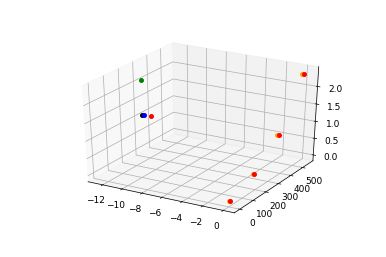

In [19]:
%matplotlib notebook
o1 = TF1@np.array([0,0,0,1])
x1 = TF1@np.array([1,0,0,1])
y1 = TF1@np.array([0,1,0,1])
z1 = TF1@np.array([0,0,1,1])
print(trimble_1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(o1[0][0],o1[0][1],o1[0][2], color='black')
ax.scatter(y1[0][0],y1[0][1],y1[0][2], color='r')
ax.scatter(z1[0][0],z1[0][1],z1[0][2], color='g')
ax.scatter(x1[0][0],x1[0][1],x1[0][2], color='b')

ax.scatter(tp1[0][0][0],tp1[0][0][1],tp1[0][0][2], color='r')
ax.scatter(tp1[0][1][0],tp1[0][1][1],tp1[0][1][2], color='r')
ax.scatter(tp1[0][2][0],tp1[0][2][1],tp1[0][2][2], color='r')
ax.scatter(tp1[0][3][0],tp1[0][3][1],tp1[0][3][2], color='r')

#ax.scatter(trimble_1.T[0][0],trimble_1.T[0][1],trimble_1.T[0][2], color='black')
#ax.scatter(trimble_1.T[1][0],trimble_1.T[1][1],trimble_1.T[1][2], color='r')
#ax.scatter(trimble_1.T[2][0],trimble_1.T[2][1],trimble_1.T[2][2], color='g')
#ax.scatter(trimble_1.T[3][0],trimble_1.T[3][1],trimble_1.T[3][2], color='b')

ax.scatter(pilier_A[0],pilier_A[1],pilier_A[2], color='orange')
ax.scatter(pilier_B[0],pilier_B[1],pilier_B[2], color='orange')
ax.scatter(pilier_C[0],pilier_C[1],pilier_C[2], color='orange')
ax.scatter(pilier_D[0],pilier_D[1],pilier_D[2], color='orange')




In [20]:
print(error_12_x)
print(error_12_y)
print(error_12_z)
print(error_13_x)
print(error_13_y)
print(error_13_z)
print(error_23_x)
print(error_23_y)
print(error_23_z)
trimble_1 = trimble_1.T
print(np.linalg.norm(tp1[0][0]-tp1[0][3])-548.578)
print(np.linalg.norm(trimble_1[0] - trimble_1[3])-548.578)
print(np.linalg.norm(liste_piliers[0]-liste_piliers[3])-548.578)
print(error_1_x)
print(error_1_y)
print(error_1_z)
print(error_2_x)
print(error_2_y)
print(error_2_z)
print(error_3_x)
print(error_3_y)
print(error_3_z)

[-0.012017178065255152, -0.009523957807993533, -0.01041803823990417, -0.0064136700527797075]
[0.0023929180658797122, 0.0033734055547824937, -0.004009982171396587, -0.00269165028464613]
[-0.0019223103137925301, -0.00211044297884716, 0.002558292038661314, 0.001922310313791975]
[0.09319204646142865, 0.09114511405202741, 0.09412049232790842, 0.09798000117683081]
[0.0032722848221169443, 0.0029426982200106977, -0.0067188984864969825, -0.004199919561870047]
[-0.0005661944438941635, 5.6806047604385235e-05, -0.0021239291200694232, 0.0005661944438939415]
[0.1052092245266838, 0.10066907186002094, 0.1045385305678126, 0.10439367122961052]
[0.000879366756237232, -0.000430707334771796, -0.002708916315100396, -0.001508269277223917]
[0.0013561158698983666, 0.0021672490264515454, -0.004682221158730737, -0.0013561158698980336]
-0.01215442267130129
-0.012154422671414977
0.0
[0.13565026227612265, 0.12641027773459435, 0.13144481684380516, 0.12751642655189777]
[0.00591827635730624, 0.004175246481707973, -0.0

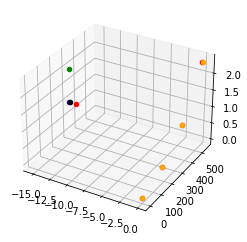

In [23]:
%matplotlib inline
o1 = TF1@np.array([0,0,0,1])
x1 = TF1@np.array([1,0,0,1])
y1 = TF1@np.array([0,1,0,1])
z1 = TF1@np.array([0,0,1,1])
print(trimble_1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(o1[0][0],o1[0][1],o1[0][2], color='black')
ax.scatter(y1[0][0],y1[0][1],y1[0][2], color='r')
ax.scatter(z1[0][0],z1[0][1],z1[0][2], color='g')
ax.scatter(x1[0][0],x1[0][1],x1[0][2], color='b')

ax.scatter(tp1[0][0][0],tp1[0][0][1],tp1[0][0][2], color='r')
ax.scatter(tp1[0][1][0],tp1[0][1][1],tp1[0][1][2], color='r')
ax.scatter(tp1[0][2][0],tp1[0][2][1],tp1[0][2][2], color='r')
ax.scatter(tp1[0][3][0],tp1[0][3][1],tp1[0][3][2], color='r')

#ax.scatter(trimble_1.T[0][0],trimble_1.T[0][1],trimble_1.T[0][2], color='black')
#ax.scatter(trimble_1.T[1][0],trimble_1.T[1][1],trimble_1.T[1][2], color='r')
#ax.scatter(trimble_1.T[2][0],trimble_1.T[2][1],trimble_1.T[2][2], color='g')
#ax.scatter(trimble_1.T[3][0],trimble_1.T[3][1],trimble_1.T[3][2], color='b')

ax.scatter(pilier_A[0],pilier_A[1],pilier_A[2], color='orange')
ax.scatter(pilier_B[0],pilier_B[1],pilier_B[2], color='orange')
ax.scatter(pilier_C[0],pilier_C[1],pilier_C[2], color='orange')
ax.scatter(pilier_D[0],pilier_D[1],pilier_D[2], color='orange')




In [26]:
print(error_12_x)
print(error_12_y)
print(error_12_z)
print(error_13_x)
print(error_13_y)
print(error_13_z)
print(error_23_x)
print(error_23_y)
print(error_23_z)
trimble_1 = trimble_1.T
print(np.linalg.norm(tp1[0][0]-tp1[0][3])-548.578)
print(np.linalg.norm(trimble_1[0] - trimble_1[3])-548.578)
print(np.linalg.norm(liste_piliers[0]-liste_piliers[3])-548.578)
print(error_1_x)
print(error_1_y)
print(error_1_z)
print(error_2_x)
print(error_2_y)
print(error_2_z)
print(error_3_x)
print(error_3_y)
print(error_3_z)

[-0.059104825312449094, -0.05602222166993798, -0.06488169789832199, -0.07294833343762264]
[-0.0017160370428541682, -0.0019987757691524166, 0.004464994897261931, 0.002707705808575156]
[0.004578600826167234, -0.0025713270995251225, -0.005508613452986477, -0.004578600826167456]
[-0.042338687831281696, -0.038987335169592185, -0.04561533481519309, -0.04532237289600083]
[-0.0002406341318419436, 5.0790161878921936e-05, 0.0012137917016161737, 0.000813464111047324]
[0.002293750915598358, -0.0008080217799181222, -0.00381842217093209, -0.0022937509155984692]
[0.016766137481167398, 0.01703488650034579, 0.0192663630831289, 0.027625960541621808]
[0.0014754029110122246, 0.0020495659310313386, -0.0032512031956457577, -0.001894241697527832]
[-0.0022848499105688758, 0.0017633053196070003, 0.0016901912820543874, 0.002284849910568987]
-0.0006152687202529705
-144.3281061791767
0.0
[0.011549003124704527, 0.014188731943903576, 0.012757802526925488, -0.0004768056280717303]
[0.0006067489198358089, -6.503617370

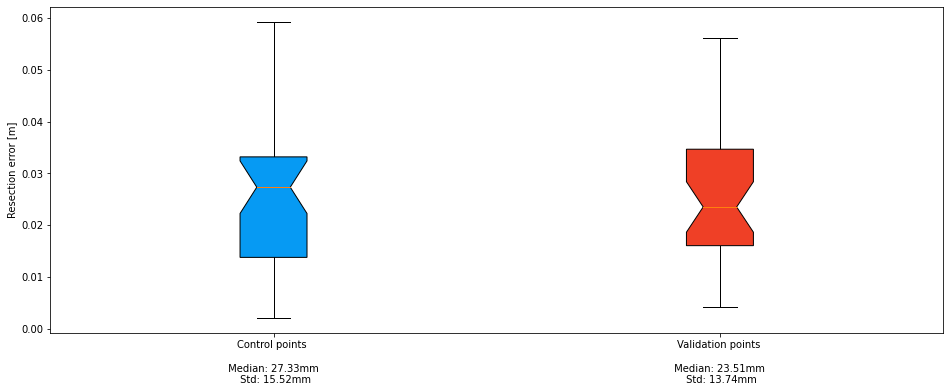

In [25]:
fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([error_control_points, error_validation_points], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2], ["Control points \n\n Median: "+str(round(np.median(error_control_points)*1000,2))+"mm \n Std: "+str(round(np.std(error_control_points)*1000,2))+"mm",
                          "Validation points \n\n Median: "+str(round(np.median(error_validation_points)*1000,2))+"mm \n Std: "+str(round(np.std(error_validation_points)*1000,2))+"mm"])
colors_box = ['#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error [m]")
plt.show()
#fig.savefig("./figs/new_resection_datasets_prior_only-f-2-1-1-1-6-1-L.jpg")

In [27]:
for i in range(len(station_1_pos2)):
    print(station_1_pos2[i] - station_2_pos2[i])
    print(station_1_pos2[i] - station_3_pos2[i])
    print(station_2_pos2[i] - station_3_pos2[i])

[-5.5979221  -1.65980795 -0.01024062  0.          0.          0.        ]
[-10.57605201  -0.50059571   0.06758436   0.           0.
   0.        ]
[-4.97812991  1.15921223  0.07782498  0.          0.          0.        ]
[-5.62402355 -1.66051127 -0.00877198  0.          0.          0.        ]
[-10.60898876  -0.50082464   0.06908956   0.           0.
   0.        ]
[-4.98496521  1.15968663  0.07786154  0.          0.          0.        ]
[-5.65162613 -1.66111457 -0.00923698  0.          0.          0.        ]
[-10.64170745  -0.50077312   0.06832722   0.           0.
   0.        ]
[-4.99008132  1.16034145  0.07756421  0.          0.          0.        ]
[-5.61755080e+00 -1.66120897e+00 -5.19701345e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-10.60058168  -0.50105174   0.07064044   0.           0.
   0.        ]
[-4.98303088  1.16015723  0.07583746  0.          0.          0.        ]
[-5.62816289 -1.66175806 -0.00566202  0.          0.          0.        ]
[-10.612541    -0

In [43]:
# print('station 1, distance A-D après TF', (np.linalg.norm(tp1[0][0]-tp1[0][3])-548.578)*1000, 'mm')
print('station 1, distance A-D avant TF', (np.linalg.norm(trimble_1[:,0] - trimble_1[:,3])-548.578)*1000, 'mm')
# print('station 1, distance A-C après TF', (np.linalg.norm(tp1[0][0]-tp1[0][2])-363.492)*1000, 'mm')
print('station 1, distance A-C avant TF', (np.linalg.norm(trimble_1[:,0] - trimble_1[:,2])-363.492)*1000, 'mm')
# print('station 1, distance A-B après TF', (np.linalg.norm(tp1[0][0]-tp1[0][1])-181.016)*1000, 'mm')
print('station 1, distance A-B avant TF', (np.linalg.norm(trimble_1[:,0] - trimble_1[:,1])-181.016)*1000, 'mm')
# print('station 2, distance A-D après TF', (np.linalg.norm(tp2[0][0]-tp2[0][3])-548.578)*1000, 'mm')
print('station 2, distance A-D avant TF', (np.linalg.norm(trimble_2[:,0] - trimble_2[:,3])-548.578)*1000, 'mm')
# print('station 2, distance A-C après TF', (np.linalg.norm(tp2[0][0]-tp2[0][2])-363.492)*1000, 'mm')
print('station 2, distance A-C avant TF', (np.linalg.norm(trimble_2[:,0] - trimble_2[:,2])-363.492)*1000, 'mm')
# print('station 2, distance A-B après TF', (np.linalg.norm(tp2[0][0]-tp2[0][1])-181.016)*1000, 'mm')
print('station 2, distance A-B avant TF', (np.linalg.norm(trimble_2[:,0] - trimble_2[:,1])-181.016)*1000, 'mm')
# print('station 3, distance A-D après TF', (np.linalg.norm(tp3[0][0]-tp3[0][3])-548.578)*1000, 'mm')
print('station 3, distance A-D avant TF', (np.linalg.norm(trimble_3[:,0] - trimble_3[:,3])-548.578)*1000, 'mm')
# print('station 3, distance A-C après TF', (np.linalg.norm(tp3[0][0]-tp3[0][2])-363.492)*1000, 'mm')
print('station 3, distance A-C avant TF', (np.linalg.norm(trimble_3[:,0] - trimble_3[:,2])-363.492)*1000, 'mm')
# print('station 3, distance A-B après TF', (np.linalg.norm(tp3[0][0]-tp3[0][1])-181.016)*1000, 'mm')
print('station 3, distance A-B avant TF', (np.linalg.norm(trimble_3[:,0] - trimble_3[:,1])-181.016)*1000, 'mm')

station 1, distance A-D avant TF -0.6152687201392837 mm
station 1, distance A-C avant TF 0.7349927239488352 mm
station 1, distance A-B avant TF -0.6700228421436805 mm
station 2, distance A-D avant TF -4.999535144975198 mm
station 2, distance A-C avant TF -5.416940466886899 mm
station 2, distance A-B avant TF -0.37436540307567157 mm
station 3, distance A-D avant TF -1.6496131780741052 mm
station 3, distance A-C avant TF -0.7018580473072689 mm
station 3, distance A-B avant TF -0.9558864923917554 mm
